# Time series with Azure Open AI

In [1]:
import datetime
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import seaborn as sns
import sys

from dotenv import load_dotenv

In [2]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

print("Open AI version:", openai.__version__)

Open AI version: 0.28.1


In [3]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 23-Oct-2023 08:42:20


## Time series dataset

In [5]:
ts_file = "timeserie.csv"

In [6]:
!ls $ts_file -lh

-rwxrwxrwx 1 root root 2.4K Oct 16 13:36 timeserie.csv


In [7]:
df = pd.read_csv(ts_file)

df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")
df = df.set_index("date")
df

,y
date,
2010-01-01,112.0
2010-02-01,118.0
2010-03-01,132.0
2010-04-01,129.0
2010-05-01,121.0
...,...
2021-08-01,606.0
2021-09-01,508.0
2021-10-01,461.0


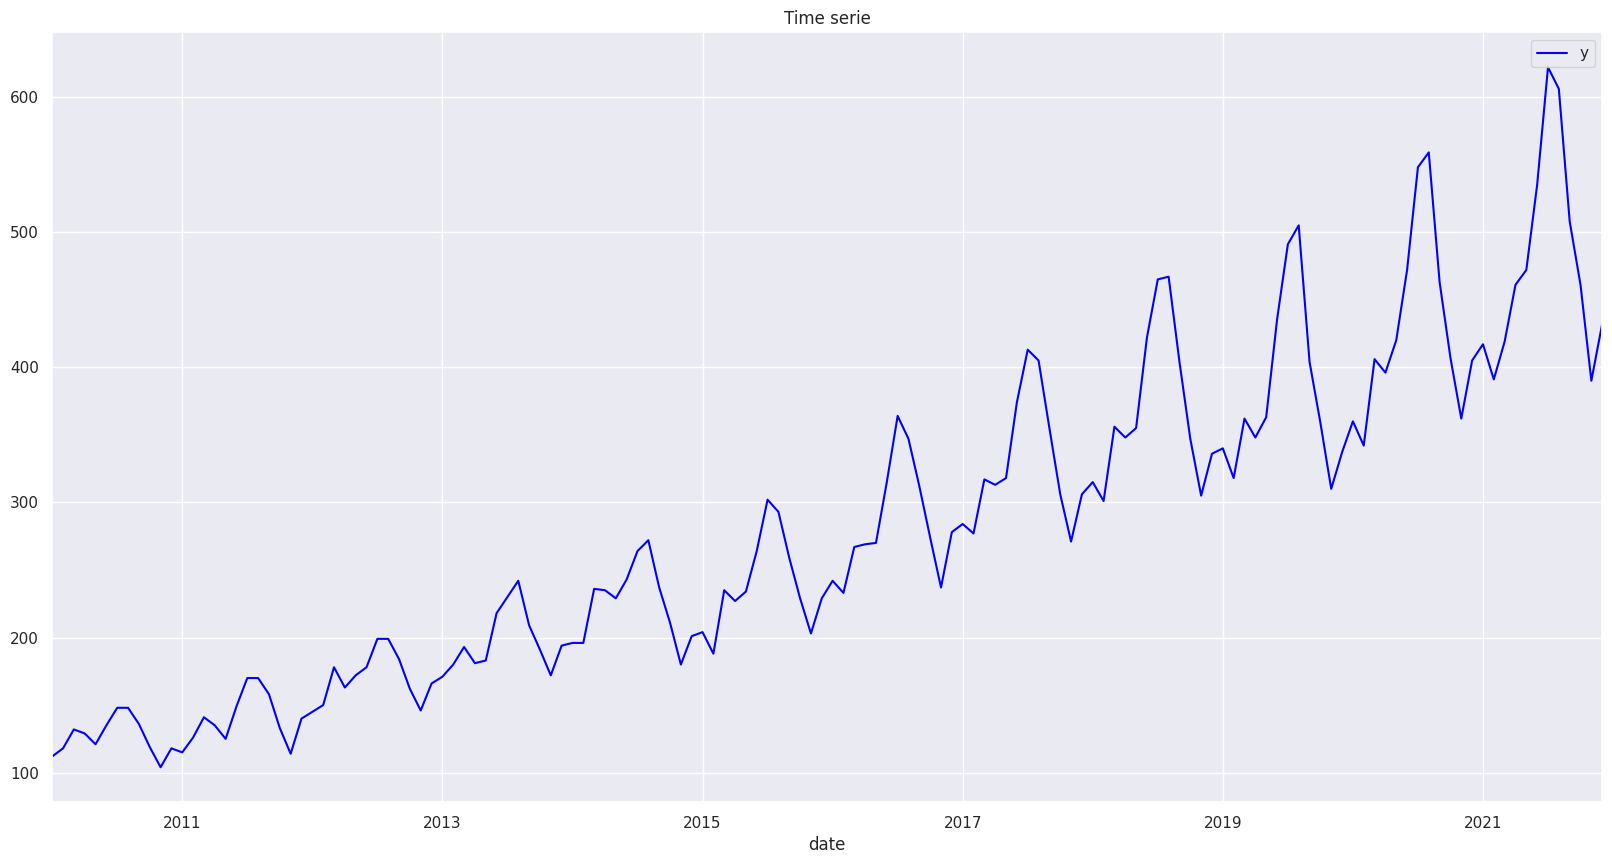

In [8]:
plt.rcParams["figure.figsize"] = [20, 10]
sns.set_theme(palette="Set2")
df.plot(title="y", color="blue")
plt.title("Time serie")
plt.show()

In [9]:
nb = 24

df_test = df.iloc[-nb:]
df_train = df.iloc[:-nb]
len(df_test), len(df_train)

(24, 120)

## Azure Open AI for forecasting

In [10]:
model = "gpt-35-turbo"

In [11]:
def chat_gpt_forecast(
    data, horizon, frequency, time_idx="date", forecast_col="forecast", model=model
):
    prompt = f""" 
    Given the dataset delimited by the triple backticks, 
    forecast next {horizon} values of the time series. 
    The time series is a {frequency} time series.

    Return the answer in JSON format, containing two keys: '{time_idx}' 
    and '{forecast_col}', and list of values assigned to them. 
    Return only the forecasts, not the Python code.

    ``` {data.to_string()}``` 
    """

    messages = [{"role": "user", "content": prompt}]

    response = openai.ChatCompletion.create(
        engine=model,
        messages=messages,
        temperature=0,
    )

    df = pd.DataFrame(json.loads(response.choices[0].message["content"]))

    return df

In [12]:
df_forecasts = chat_gpt_forecast(df_train, 24, "monthly")

In [13]:
df_forecasts

,date,forecast
0,2020-01-01,365.0
1,2020-02-01,338.0
2,2020-03-01,385.0
3,2020-04-01,376.0
4,2020-05-01,387.0
5,2020-06-01,460.0
6,2020-07-01,514.0
7,2020-08-01,526.0
8,2020-09-01,422.0
9,2020-10-01,376.0


In [14]:
df_test.reset_index(drop=False, inplace=True)

all_df = pd.concat([df_forecasts, df_test["y"]], axis=1)
all_df["diff"] = all_df["forecast"] - all_df["y"]
all_df["pct_diff"] = ((all_df["forecast"] - all_df["y"]) / all_df["y"]) * 100
all_df

,date,forecast,y,diff,pct_diff
0,2020-01-01,365.0,360.0,5.0,1.388889
1,2020-02-01,338.0,342.0,-4.0,-1.169591
2,2020-03-01,385.0,406.0,-21.0,-5.172414
3,2020-04-01,376.0,396.0,-20.0,-5.050505
4,2020-05-01,387.0,420.0,-33.0,-7.857143
5,2020-06-01,460.0,472.0,-12.0,-2.542373
6,2020-07-01,514.0,548.0,-34.0,-6.204380
7,2020-08-01,526.0,559.0,-33.0,-5.903399
8,2020-09-01,422.0,463.0,-41.0,-8.855292
9,2020-10-01,376.0,407.0,-31.0,-7.616708


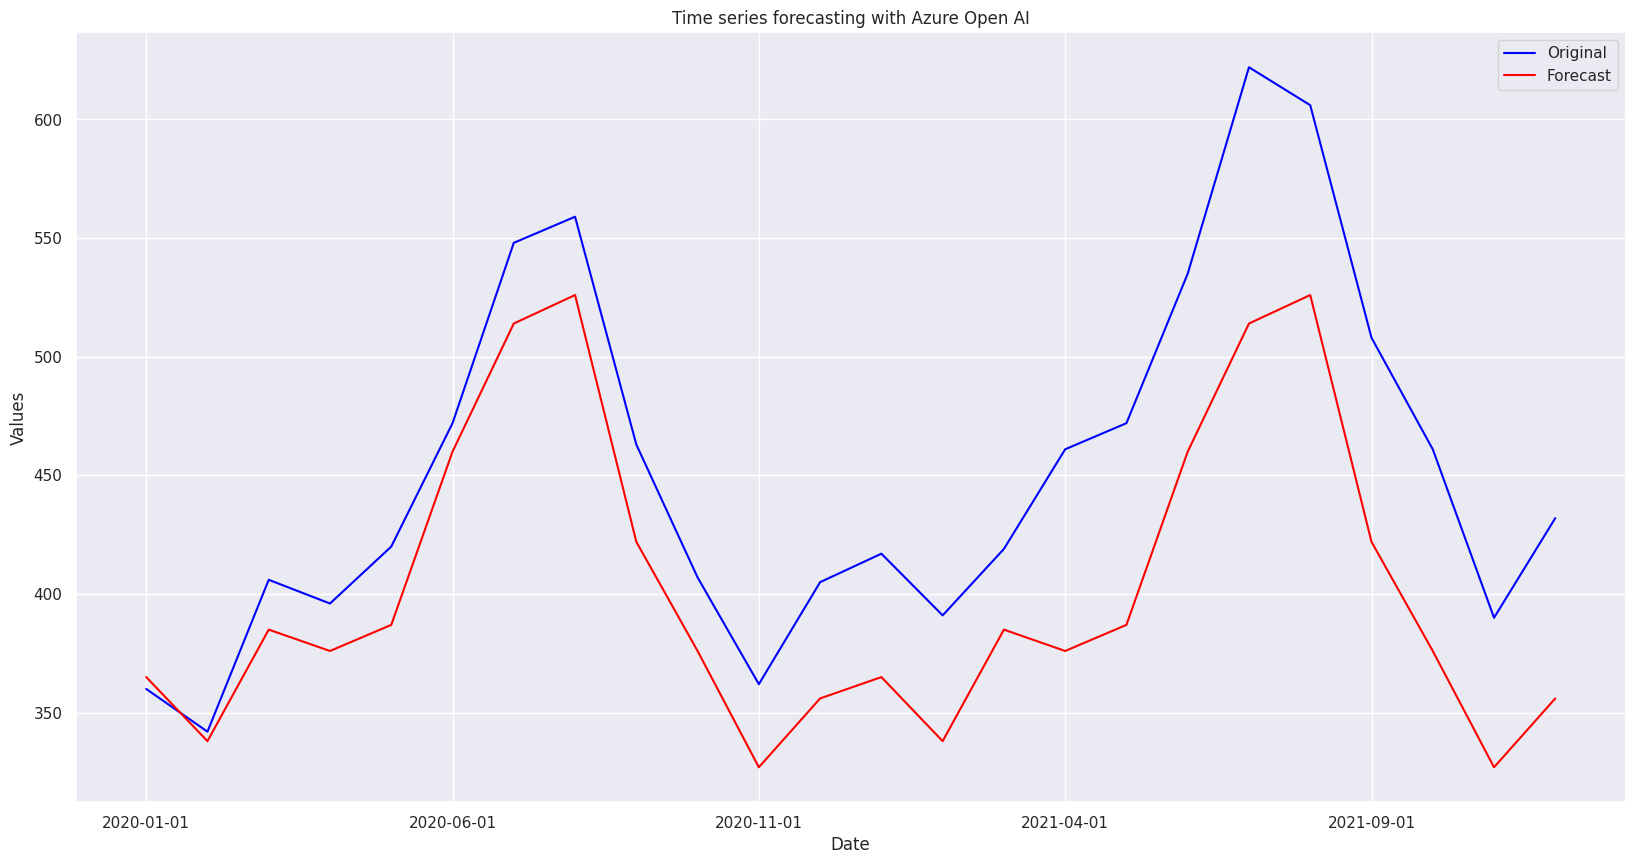

In [15]:
all_df.plot(x="date", y=["y", "forecast"], color=["blue", "red"])

plt.title("Time series forecasting with Azure Open AI")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend(["Original", "Forecast"])
plt.grid(True)

plt.show()

In [16]:
df_forecasts["date"] = pd.to_datetime(df_forecasts["date"], format="%Y-%m-%d")
df_allresults = pd.merge(df, df_forecasts, on="date", how="left")

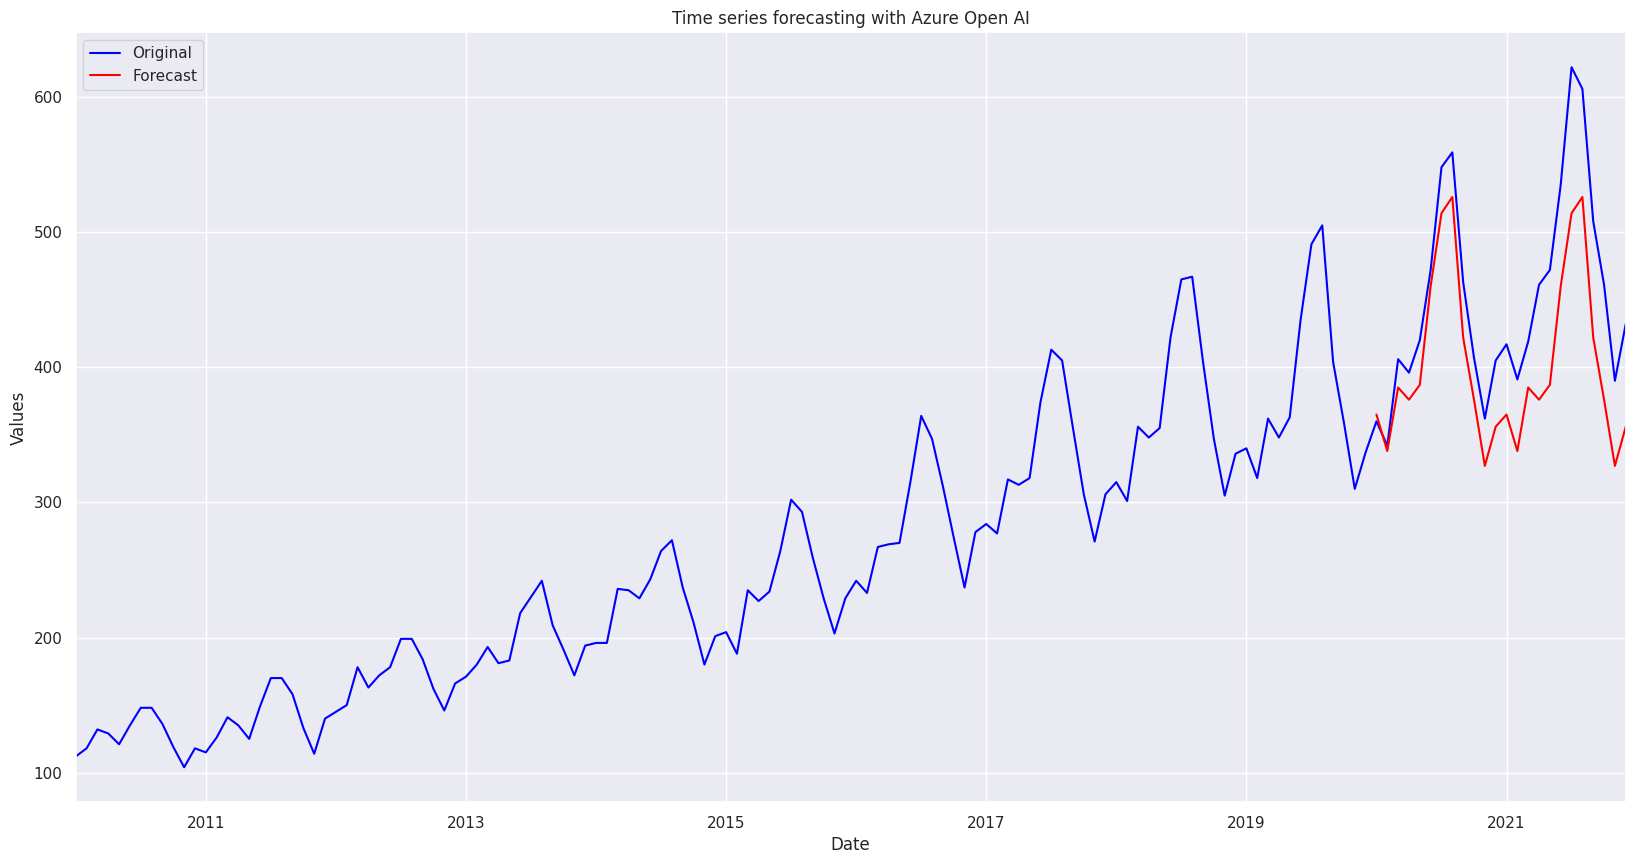

In [17]:
df_allresults.plot(x="date", y=["y", "forecast"], color=["blue", "red"])

plt.title("Time series forecasting with Azure Open AI")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend(["Original", "Forecast"])
plt.grid(True)
plt.legend(["Original", "Forecast"])
plt.show()

## Q&A on a time serie with Azure Open AI

In [18]:
def ask_timeserie(prompt):
    """
    Ask Time series
    """
    query = f"{prompt} of {df}."

    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=query,
        temperature=0,
        max_tokens=1000,
        n=1,
        stop=None,
    )

    return response["choices"][0]["text"].replace("\n\n", "")

In [20]:
prompt = "What are the min and max values?"

print(ask_timeserie(prompt))

Min value: 112.0
Max value: 606.0


In [21]:
prompt = "What are the min and max dates?"

print(ask_timeserie(prompt))

Min date: 2010-01-01
Max date: 2021-12-01


In [22]:
prompt = "What are the mean and median values?"

print(ask_timeserie(prompt))

Mean: 393.5
Median: 397.5


In [23]:
prompt = "What is the variance of this time serie?"

print(ask_timeserie(prompt))

The variance of this time series is 8,945.


In [24]:
prompt = "Forecast the next data point in this time series"

print(ask_timeserie(prompt))

2022-01-01  474.0


In [25]:
prompt = "What is the trend of this time serie?"

print(ask_timeserie(prompt))

The trend of this time series is an overall upward trend.


In [26]:
prompt = "What is the periodicity of this time serie?"

print(ask_timeserie(prompt))

The periodicity of this time series is monthly.


In [27]:
prompt = "Take the last 2 values and generate the mean of it"

print(ask_timeserie(prompt))

Mean of the last 2 values = (461.0 + 390.0) / 2 = 425.5


In [28]:
prompt = "Take the last 3 values and generate the mean of it"

print(ask_timeserie(prompt))

The mean of the last 3 values is 467.0.


In [29]:
prompt = "How is the average variation in %?"

print(ask_timeserie(prompt))

The average variation in % of y is 8.33%.


In [31]:
prompt = "How do you define this time serie in terms of trend, seasonnality and cyclical part?"

print(ask_timeserie(prompt))

This time series appears to have an overall upward trend, with some seasonal fluctuations. The seasonality appears to be a yearly cycle, with higher values in the first half of the year and lower values in the second half. There does not appear to be any cyclical component.
